In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_ei_basic
from bo_functions import calc_y_exp
from bo_functions import create_sse_data
from bo_functions import create_y_data
from bo_functions import ExactGPModel
from bo_functions import calc_GP_outputs
from bo_functions import train_GP_model
from bo_functions import calc_ei_basic_tot

from bo_plotters import plot_hyperparams
from bo_plotters import stdev_plotter
from bo_plotters import y_plotter
from bo_plotters import ei_plotter
from bo_plotters import plot_xy

In [2]:
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
noise_stdev = 0.1**2
inputs = 2
# print(x)

In [3]:
#Set Theta_True and Yexp
Theta_True = np.array([[2,-1],[-1,1],[1,2]])
Num_Theta = len(Theta_True)
n = len(Xexp)
Yexp = np.zeros((Num_Theta,n))
for i in range(len(Theta_True)):
    Yexp[i] = calc_y_exp(Theta_True[i], Xexp, noise_stdev)

In [4]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
t = len(train_T)
q= 2
q_y = 3

train_sse = np.zeros((Num_Theta,t))
for i in range(len(Theta_True)):
    train_sse[i] = create_sse_data(q,train_T, Xexp, Yexp[i])
# print(train_sse)

In [5]:
p=10
#Define Testing Space
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]
# print(test_T)

Noise Hyperparameter:  1.0
Lengthscale Hyperparameter:  1.0
Outputscale Hyperparameter:  1.0
The GP predicts that Theta = [ 1.55555556 -1.55555556]
The GP estimates the highest EI is at Theta =  [ 1.55555556 -1.55555556]


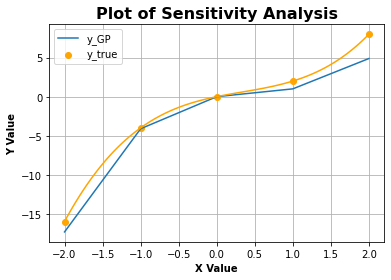

Noise Hyperparameter:  1.0
Lengthscale Hyperparameter:  1.0
Outputscale Hyperparameter:  1.0
The GP predicts that Theta = [-1.11111111  1.11111111]
The GP estimates the highest EI is at Theta =  [-1.11111111  1.11111111]


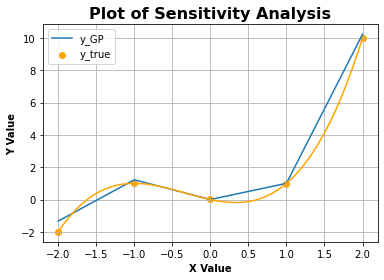

Noise Hyperparameter:  1.0
Lengthscale Hyperparameter:  1.0
Outputscale Hyperparameter:  1.0
The GP predicts that Theta = [0.66666667 2.        ]
The GP estimates the highest EI is at Theta =  [0.66666667 2.        ]


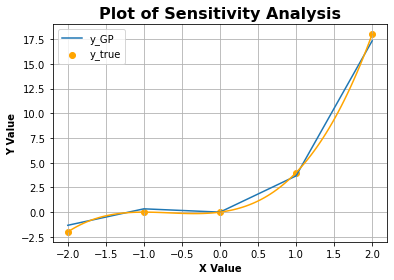

In [6]:
for i in range(Num_Theta):
    # initialize likelihood and model
    ##Assumes a homoskedastic noise model p(y | f) = f + noise
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    # We will use the simplest form of GP model, exact inference
    #Defines our model in terms of the class parameters in bo_functions
    model = ExactGPModel(train_T, train_sse[i], likelihood)

    #Training the GP Model
    iterations = 300
    train_GP = train_GP_model(model, likelihood, train_T, train_sse[i], iterations, verbose = False)
    noise_list = train_GP[0]
    lengthscale_list = train_GP[1]
    outputscale_list = train_GP[2]

    #Plot hyperparameters vs iteration
#     noise_title = "Noise Hyperparameter"
#     lengthscale_title = "Lengthscale Hyperparameter"
#     outputscale_title = "Outputscale Hyperparameter"
#     plot_hyperparams(iterations, noise_list,noise_title)
#     plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
#     plot_hyperparams(iterations, outputscale_list,outputscale_title)

    #Change GP Hyperparameters
    outputscale = torch.tensor([1])
    lengthscale = torch.tensor([1])
    noise = torch.tensor([1])

    model.likelihood.noise = noise
    model.covar_module.base_kernel.lengthscale =lengthscale
    model.covar_module.outputscale = outputscale

    print("Noise Hyperparameter: ", float(model.likelihood.noise))
    print("Lengthscale Hyperparameter: ", float(model.covar_module.base_kernel.lengthscale))
    print("Outputscale Hyperparameter: ", float(model.covar_module.outputscale))

    # Get into evaluation (predictive posterior) mode
    #Puts model in evaluation mode
    model.eval()
    #Puts likelihood in evaluation mode
    likelihood.eval()

    ei_components = calc_ei_basic_tot(p,theta_mesh, train_sse[i], model, likelihood)
    ei = ei_components[0]
    sse = ei_components[1]
    var = ei_components[2]
    stdev = ei_components[3]

    #Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
    argmin = np.array(np.where(np.isclose(sse, np.amin(sse),atol=1e-10)==True))
    Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
    Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
    Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))
    print("The GP predicts that Theta =",Theta_Opt_GP)

    #calculates best theta value
    argmax = np.array(np.where(np.isclose(ei, np.amax(ei),atol=1e-10)==True))
#     print(argmax)
    Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
    Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
    Theta_Best = np.array((Theta_1_Best,Theta_2_Best))
    print("The GP estimates the highest EI is at Theta = ",Theta_Best)

    title = "Sensitivity Analysis"
    
    y_GP_input = np.zeros((n,3))
    for j in range(n):
        y_GP_input[j] = np.array([Theta_Best[0],Theta_Best[1],Xexp[j]])
    
    y_GP = create_y_data(q_y,y_GP_input)
#     print(y_GP,Yexp[i])
    plot_xy(Xexp, Yexp[i], y_GP,Theta_True[i],title)
#     y_plotter_basic(theta_mesh, sse, Theta_True[i], Theta_Opt_GP, train_T,title,plot_train=True)

#     stdev_plotter_basic(theta_mesh, stdev,Theta_True[i], Theta_Opt_GP,train_T,plot_train=True)

#     ei_plotter_basic(theta_mesh, ei, Theta_True[i], Theta_Opt_GP,train_T,plot_train=True)